<h1>Calories Burnt Prediction</h1>

![img-1](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExdjVuemQwOWZnZ3Q4ZHk2OGFoM3I1YTYxczBkbzBlYnBxeXR2eG1nMSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/xThuWcH0xUi4HASiHu/giphy.gif)

##0 Preparations

Importing libraries

In [ ]:
!pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import pickle

from IPython.core.pylabtools import figsize
%matplotlib inline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
calories = pd.read_csv('/content/calories.csv')

In [ ]:
exercise = pd.read_csv('/content/exercise.csv')

## 1 Dataset overview

1.**User_ID** : The ID of the person which is unique.\
2.**Gender** : Gender of the person.\
3.**Age** : Age of the person.\
4.**Height** : Height of the person in $cm$.\
5.**Weight** : Weight of the person in $kg$.\
6.**Duration** : Duration of the person's exercise/activity.\
7.**Heart_Rate** : Heart rate per $min$ of the person.\
8.**Body_Temp** : Body temperature of the person in $C^{\circ}$.\
9.**Calories** : Calories burned in kilo calories.

In [ ]:
calories.head(3)


(15000, 2)

In [ ]:
calories.shape

(15000, 2)

In [ ]:
exercise.head(3)

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7


In [ ]:
exercise.shape

(15000, 8)

Let's see that in our data the User_ID matches.

In [ ]:
(calories['User_ID'] == exercise['User_ID']).value_counts()

True    15000
Name: User_ID, dtype: int64

In [ ]:
df = exercise.merge(calories, on='User_ID')

In [ ]:
df.head(5)

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.1+ MB


There are no empty values. Good!

In [ ]:
df.drop(['User_ID'], axis = 1, inplace = True)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,15000.0,42.789800,16.980264,20.0,28.0,39.0,56.0,79.0
Height,15000.0,174.465133,14.258114,123.0,164.0,175.0,185.0,222.0
Weight,15000.0,74.966867,15.035657,36.0,63.0,74.0,87.0,132.0
Duration,15000.0,15.530600,8.319203,1.0,8.0,16.0,23.0,30.0
Heart_Rate,15000.0,95.518533,9.583328,67.0,88.0,96.0,103.0,128.0
Body_Temp,15000.0,40.025453,0.779230,37.1,39.6,40.2,40.6,41.5
Calories,15000.0,89.539533,62.456978,1.0,35.0,79.0,138.0,314.0


## 2 EDA

Let's look at the quasi-constant features.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

numeric_columns = df.loc[:,df.dtypes!=np.object].columns
cutter = VarianceThreshold(threshold=0.1)
cutter.fit(df[numeric_columns])
constant_cols = [x for x in numeric_columns if x not in cutter.get_feature_names_out()]

df[constant_cols]

Let's look at the effect of features on the target variable.

Features influences on calories
Duration      0.955421
Heart_Rate    0.897882
Body_Temp     0.824558
Age           0.154395
Weight        0.035481
Height        0.017537
Name: Calories, dtype: float64


<Figure size 800x600 with 0 Axes>

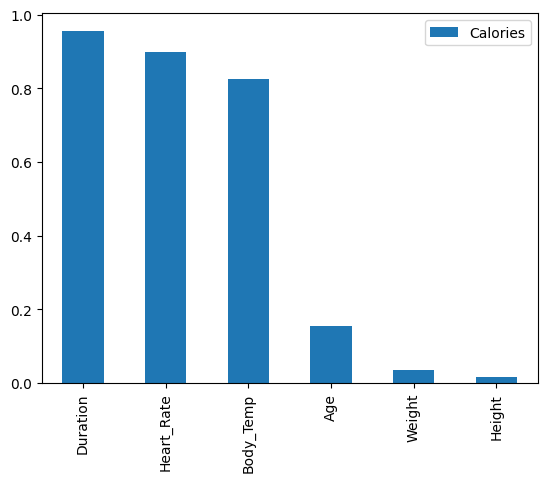

In [ ]:
plt.figure(figsize = (8, 6))
corrs = df.copy().corr()['Calories']
corrs = corrs.sort_values(ascending=False).drop('Calories',axis=0)
print(corrs)
corrs.to_frame().plot.bar();

Also check the gender breakdown.

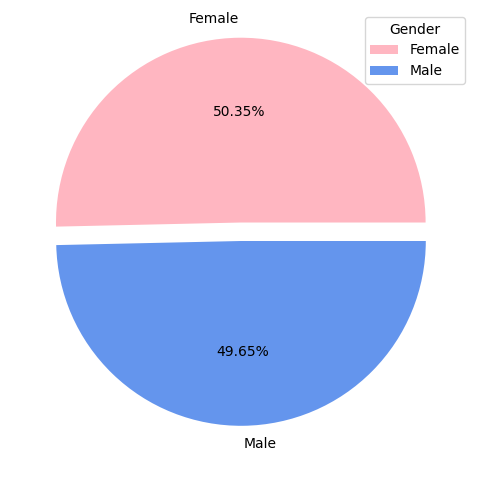

In [ ]:
plt.figure(figsize = (8, 6))
plt.pie(df['Gender'].value_counts(), explode = (0.1, 0.0), labels = ['Female', 'Male'], autopct = '%1.2f%%', colors = ['lightpink', 'cornflowerblue'])
plt.legend(title = 'Gender', loc = 'best')

We encode the **Gender** feature using binary encoding. You can not use One-hot, since there are only 2 values in it.

In [ ]:
df.replace({'Gender':{'male':0,'female':1}},inplace=True)

In [ ]:
df.head(3)

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,0,69,179.0,79.0,5.0,88.0,38.7,26.0


Let's build graphs to see the distribution of our features.

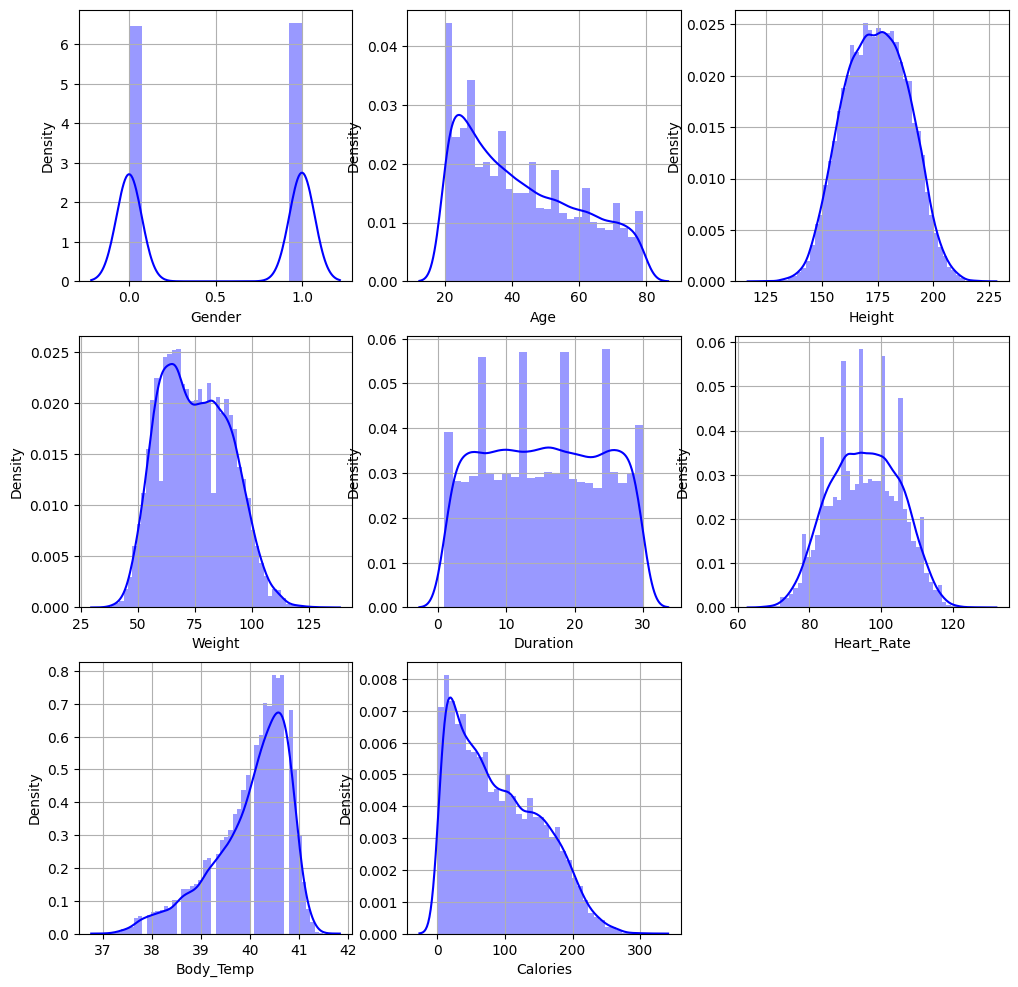

In [ ]:
plt.figure(figsize = (12, 12))

for i in range(len(df.columns)):
    plt.subplot(3, 3, i+1)
    sns.distplot(df.iloc[:, i], color = 'blue')
    plt.grid()

We have a lot of features distributed normally, which is good news! It will be easier for the model to work with such data. Also, we don't have any features, with some strong tails.\
\
Let's look at the distribution of the target by **Age**.

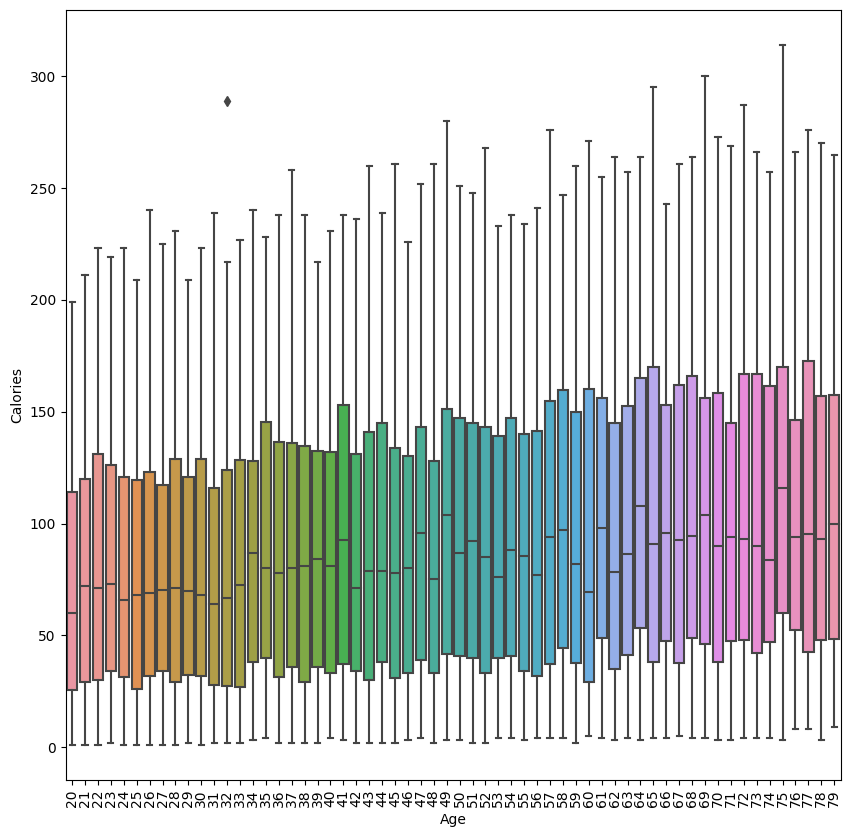

In [ ]:
fig = plt.figure()
fig.set_size_inches(10,10)

sns.boxplot(y='Calories', x=df['Age'].astype('category'), data=df)
plt.xticks(rotation=90)
plt.show()

We see that the target variable changes slightly from age to age. We can also assume based on the graph that people have some cycles of activity: people in their 20s may not have such a need for activity/ weight loss or due to lack of free time due to studies, so the median is in the range of 55-65 calories. At 21-23, people start doing more sports or various activities and their median calorie expenditure rises to 65-75 and then falls again for a while. People after 30 are already beginning to seriously think about their shape and their health, also by this age many have a financial opportunity, for example, to go to the gym all the time or pay for classes with a coach, and therefore their median activity increases to 75 and above. But all the same, there is a tendency that after some peak, people stop actively engaging in activity and return to it after a few years.\
\
Let's look at the distribution of the target by **Weight**.


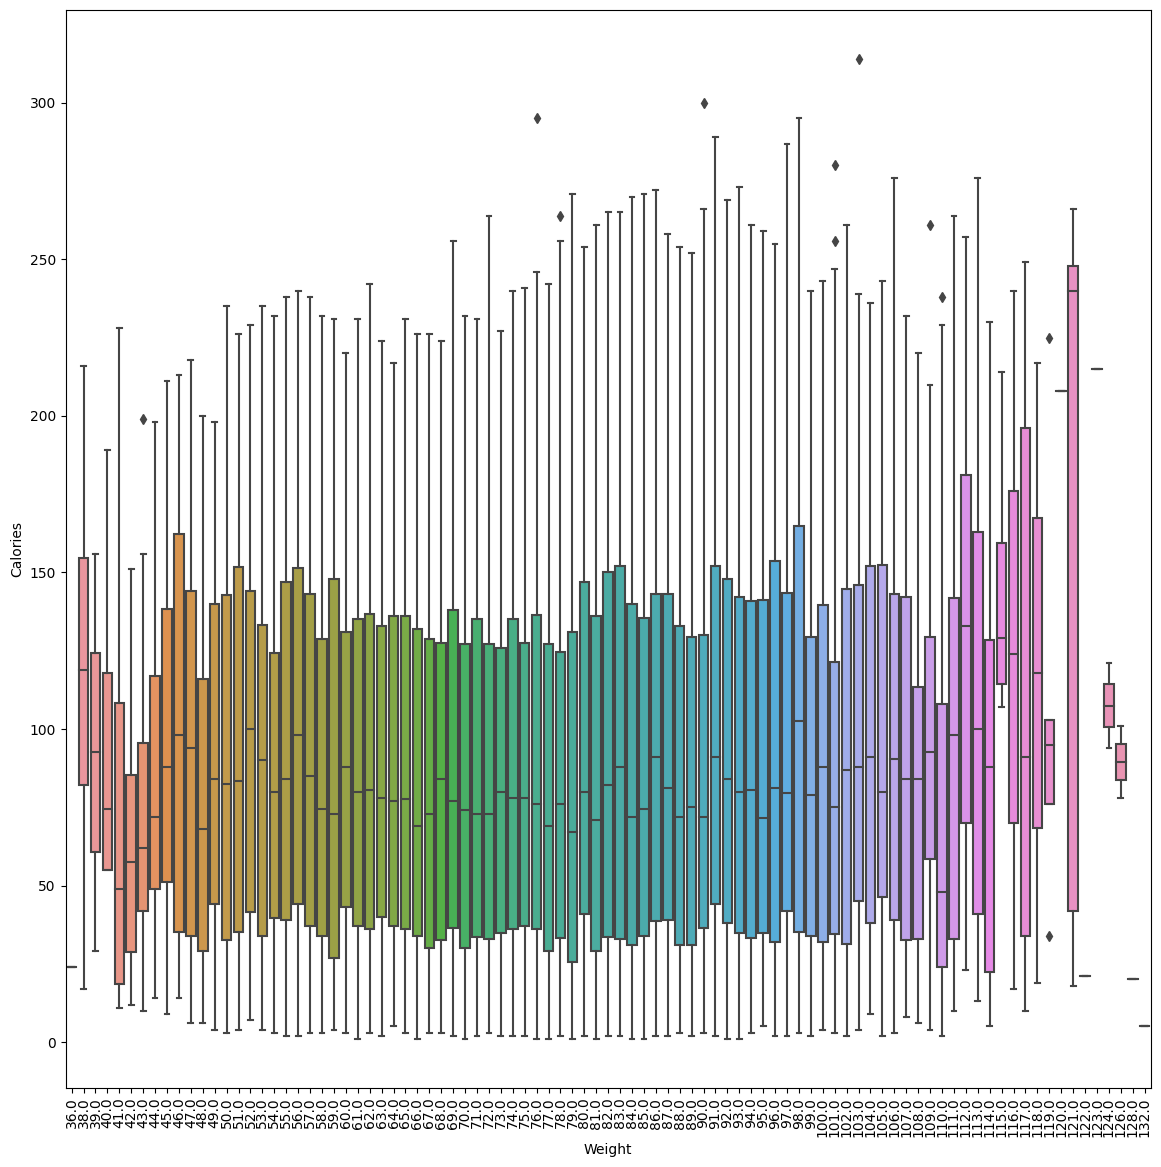

In [ ]:
fig = plt.figure()
fig.set_size_inches(14,14)

sns.boxplot(y='Calories', x=df['Weight'].astype('category'), data=df)
plt.xticks(rotation=90)
plt.show()

We also see that the target variable also changes quite well from the weight. Here we do not see a strict relationship that people with more weight spend more calories. Perhaps this is due to the fact that it is more difficult for people with a lot of weight to engage in activity. \
\
Let's look at the distribution of the target by **Heart Rate**.


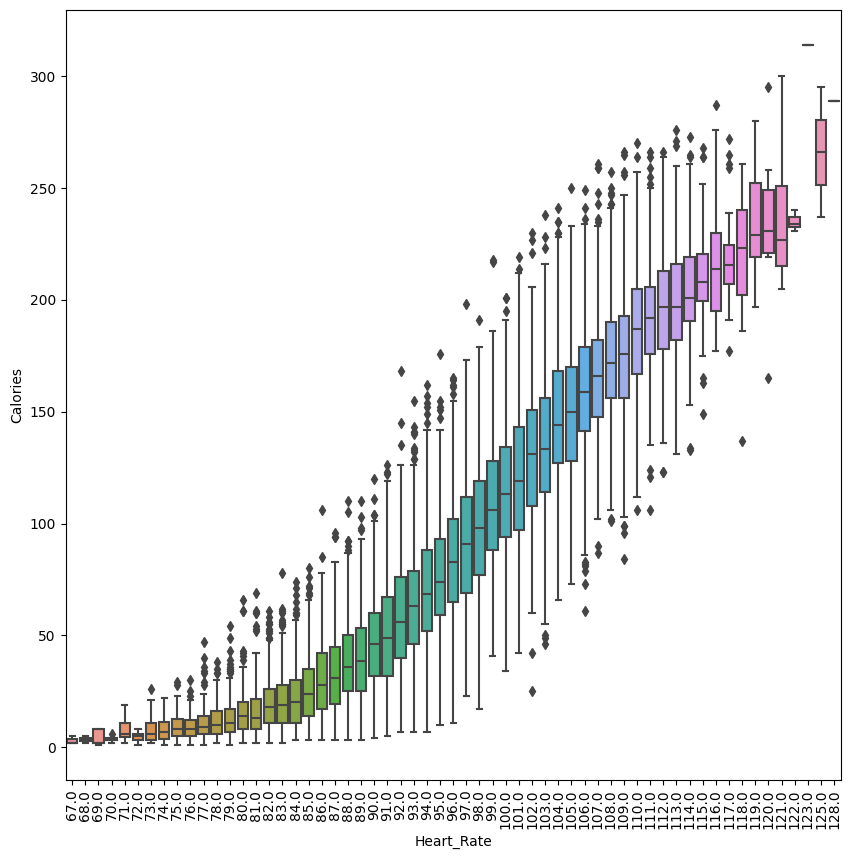

In [ ]:
fig = plt.figure()
fig.set_size_inches(10,10)

sns.boxplot(y='Calories', x=df['Heart_Rate'].astype('category'), data=df)
plt.xticks(rotation=90)
plt.show()

We see quite a logical pattern. The higher the heart rate, the more calories are spent. \
\
Let's look at the distribution of the target by **Duration** and **Body_Temp**.

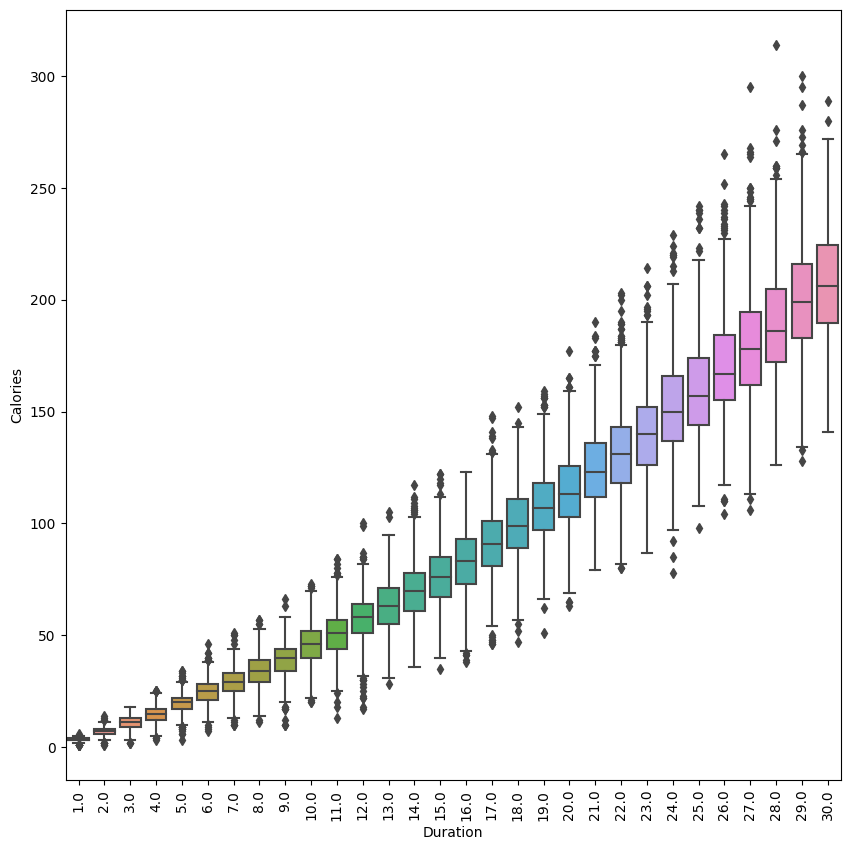

In [ ]:
fig = plt.figure()
fig.set_size_inches(10,10)

sns.boxplot(y='Calories', x=df['Duration'].astype('category'), data=df)
plt.xticks(rotation=90)
plt.show()

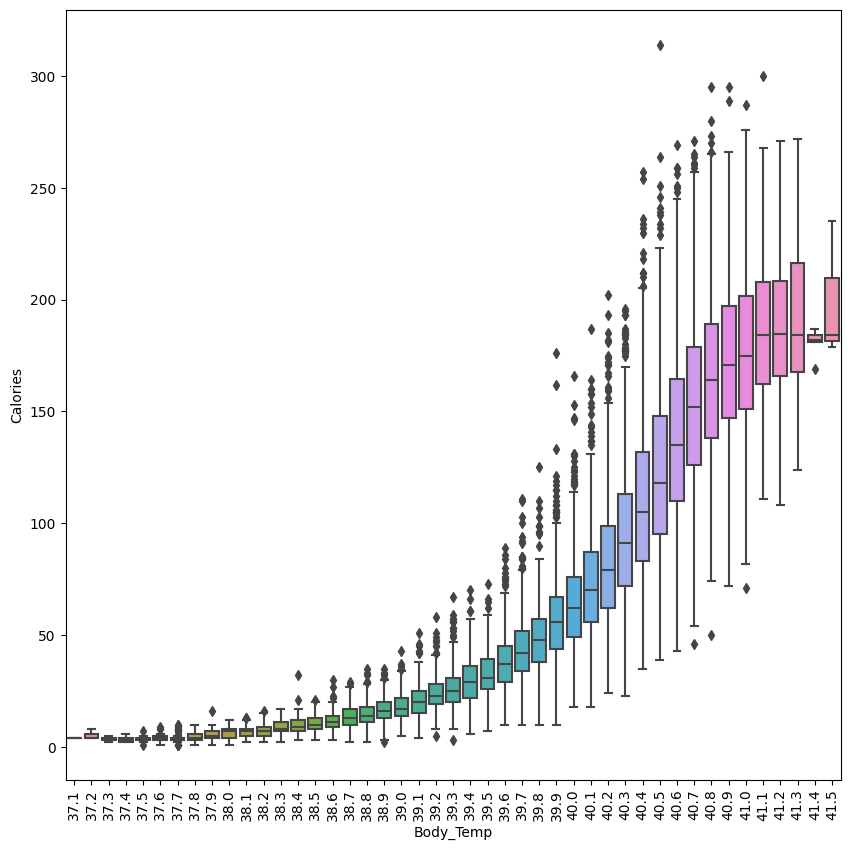

In [ ]:
fig = plt.figure()
fig.set_size_inches(10,10)

sns.boxplot(y='Calories', x=df['Body_Temp'].astype('category'), data=df)
plt.xticks(rotation=90)
plt.show()

Similarly. The longer the duration and body temperature, the more calories we spend. \
\
Let's look at the outliers and get rid of them.

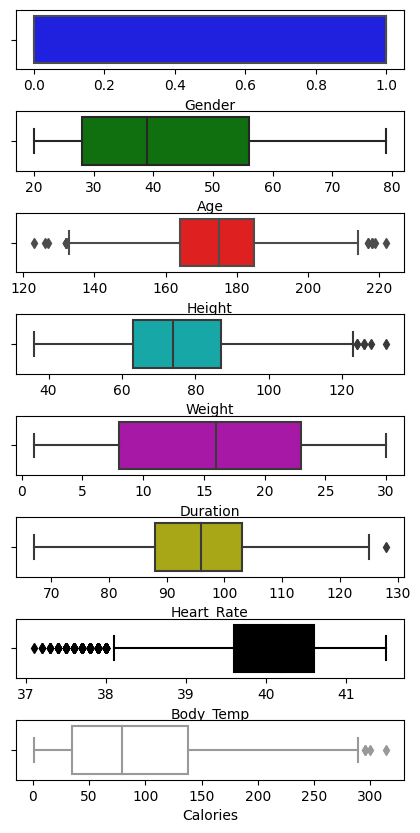

In [ ]:
c = ['b' , 'g' , 'r' , 'c' , 'm' , 'y' , 'k' , 'w' , 'b']
fig1 , axes = plt.subplots(len(df.columns) , 1 , figsize = (5 , 10))
plt.subplots_adjust(wspace = 0.3 , hspace = 0.7)
axes = axes.flatten()             #for using axes indeces with one dimention array instead of two dimension
for i , column in zip(range(len(df.columns)) , df.columns):
  try:
    sns.boxplot(data = df , x = column , color = c[i] , ax = axes[i])
  except:
    fig1.delaxes(axes[i])
    continue

In [ ]:
for col in ['Height', 'Weight', 'Body_Temp']:
  first_quartile = df[col].describe()['25%']
  third_quartile = df[col].describe()['75%']

  iqr = third_quartile - first_quartile

  df = df[(df[col] > (first_quartile - 1.5 * iqr)) & (df[col] < (third_quartile + 1.5 * iqr))]

In [ ]:
df.shape

(14524, 8)

Lost only 476 rows.

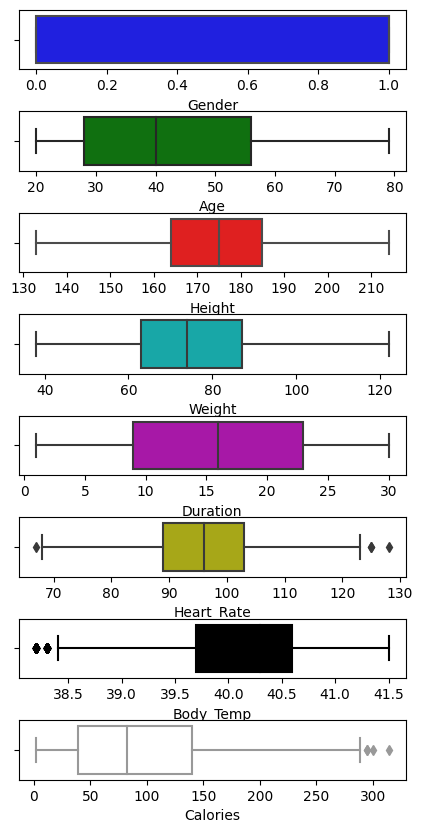

In [ ]:
c = ['b' , 'g' , 'r' , 'c' , 'm' , 'y' , 'k' , 'w' , 'b']
fig1 , axes = plt.subplots(len(df.columns) , 1 , figsize = (5 , 10))
plt.subplots_adjust(wspace = 0.3 , hspace = 0.7)
axes = axes.flatten()             #for using axes indeces with one dimention array instead of two dimension
for i , column in zip(range(len(df.columns)) , df.columns):
  try:
    sns.boxplot(data = df , x = column , color = c[i] , ax = axes[i])
  except:
    fig1.delaxes(axes[i])
    continue

I suggest combining the **Weight** and **Height** features into one fairly simple one - **BMI** (Body Mass Index) \
\
$BMI = \frac{Weight(kg)}{Height(m)^2}$

According to [this page](https://en.wikipedia.org/wiki/Body_mass_index) we will classify instances according to below table:


|   Categoty                                       | from          | to    |
| -------------------------------------------------|:-------------:| -----:|
| Very severely underweight                        | --            |  15   |
| Severely underweight                             | 15            |  16   |
| Underweight                                      | 16            |  18.5 |
| Normal (healthy weight)                          | 18.5          |  25   |
| Overweight                                       | 25            |  30   |
| Obese Class I (Moderately obese)                 | 30            |  35   |
| Obese Class II (Severely obese)                  | 35            |  40   |
| Obese Class III (Very severely obese)            | 40            |       |



In [ ]:
df["BMI"] = df["Weight"] / ((df["Height"] / 100) ** 2)
df["BMI"] = round(df["BMI"] , 2)

In [ ]:
df.head(3)

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI
0,0,68,190.0,94.0,29.0,105.0,40.8,231.0,26.04
1,1,20,166.0,60.0,14.0,94.0,40.3,66.0,21.77
2,0,69,179.0,79.0,5.0,88.0,38.7,26.0,24.66


In [ ]:
df = df.drop(['Height', 'Weight'], axis=1)

In [ ]:
df.head(3)

,Gender,Age,Duration,Heart_Rate,Body_Temp,Calories,BMI
0,0,68,29.0,105.0,40.8,231.0,26.04
1,1,20,14.0,94.0,40.3,66.0,21.77
2,0,69,5.0,88.0,38.7,26.0,24.66


Let's look at the correlation.

<Axes: >

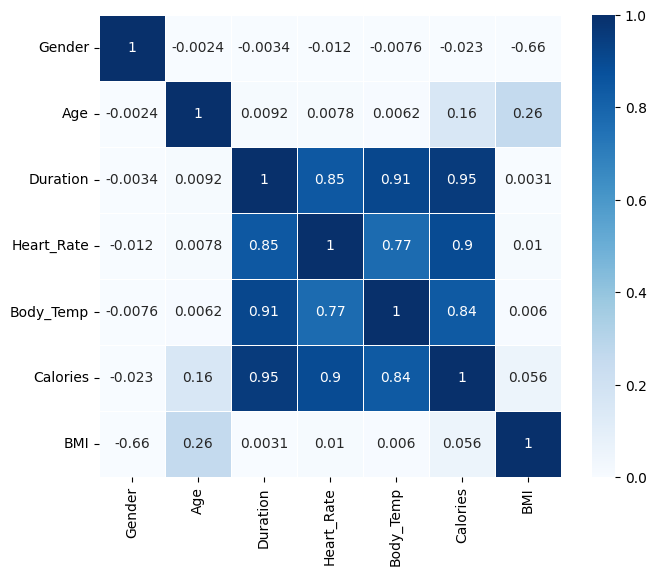

In [ ]:
plt.rcParams["figure.figsize"] = 8 , 6
corr = df.corr()
sns.heatmap(corr , annot = True , square = True , linewidth = .5 , vmin = 0 , vmax = 1 , cmap = 'Blues')

As we can see, there are almost no strong correlations greater than 0.9. We can assume that it could be larger between **Weight** and **Height**, but we combined these two features into one - **BMI**

## 3 Modeling

Some support functions for calculating metrics

In [ ]:
def r2_adjusted(y_true: np.ndarray, y_pred: np.ndarray, X_test: np.ndarray) -> float:
  N_objects = len(y_true)
  N_features = X_test.shape[1]
  r2 = r2_score(y_true, y_pred)
  return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
  return np.mean((y_true - y_pred) / y_true) * 100

def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
  return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
  return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100

def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
  try:
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
  except:
    return None

def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                X_test: np.ndarray,
                name: str = None):
  df_metrics = pd.DataFrame()
  df_metrics['model'] = [name]

  df_metrics['MAE'] = mean_absolute_error(y_test, y_pred)
  df_metrics['MSE'] = mean_squared_error(y_test, y_pred)
  df_metrics['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
  df_metrics['RMSLE'] = rmsle(y_test, y_pred)
  df_metrics['R2 adjusted'] = r2_adjusted(y_test, y_pred, X_test)
  df_metrics['MPE_%'] = mpe(y_test, y_pred)
  df_metrics['MAPE_%'] = mape(y_test, y_pred)
  df_metrics['WAPE_%'] = wape(y_test, y_pred)

  return df_metrics

def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  mae_train = metric_fun(y_train, y_pred_train)
  mae_test = metric_fun(y_test, y_pred_test)

  print(f'{metric_fun.__name__} train: %.3f' % mae_train)
  print(f'{metric_fun.__name__} test: %.3f' % mae_test)
  print(f'delta = {(abs(mae_train - mae_test)/mae_train*100):.1f} %')

In [ ]:
df.head(3)

,Gender,Age,Duration,Heart_Rate,Body_Temp,Calories,BMI
0,0,68,29.0,105.0,40.8,231.0,26.04
1,1,20,14.0,94.0,40.3,66.0,21.77
2,0,69,5.0,88.0,38.7,26.0,24.66


In [ ]:
X = df.drop('Calories', axis=1)
y = df['Calories']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state = 1)

### 3.1 Baseline

#### Linear Regression

In [ ]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)

In [ ]:
metrics = get_metrics(y_test, y_pred, X_test, 'LinearRegression_baseline')
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,8.275508,126.357433,11.240882,None,0.966645,9.165542,22.966112,9.039959


In [ ]:
check_overfitting(model_lr, X_train, y_train, X_test, y_test, metric_fun=mean_absolute_error)

mean_absolute_error train: 8.392
mean_absolute_error test: 8.276
delta = 1.4 %


#### LGBM Regressor

In [ ]:
model_lgb = LGBMRegressor(random_state=1, objective='mae')

model_lgb.fit(X_train, y_train, eval_metric='mae', verbose=False)

y_pred = model_lgb.predict(X_test)

In [ ]:
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'LGBMRegressor_baseline'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,8.275508,126.357433,11.240882,NaN,0.966645,9.165542,22.966112,9.039959
0,LGBMRegressor_baseline,2.439368,13.074090,3.615811,0.050219,0.996549,-0.507913,3.470373,2.664705


In [ ]:
check_overfitting(model_lgb, X_train, y_train, X_test, y_test, metric_fun=mean_absolute_error)

mean_absolute_error train: 2.155
mean_absolute_error test: 2.439
delta = 13.2 %


#### CatBoost Regressor

In [ ]:
model_cb = CatBoostRegressor(random_seed=1, loss_function='MAE', eval_metric='MAE', allow_writing_files=False)

model_cb.fit(X_train, y_train, verbose=0)

y_pred = model_cb.predict(X_test)

In [ ]:
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'CatBoostRegressor_baseline'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,8.275508,126.357433,11.240882,NaN,0.966645,9.165542,22.966112,9.039959
0,LGBMRegressor_baseline,2.439368,13.074090,3.615811,0.050219,0.996549,-0.507913,3.470373,2.664705
0,CatBoostRegressor_baseline,2.041668,8.967569,2.994590,0.041195,0.997633,-0.239818,2.904262,2.230267


In [ ]:
check_overfitting(model_cb, X_train, y_train, X_test, y_test, metric_fun=mean_absolute_error)

mean_absolute_error train: 1.844
mean_absolute_error test: 2.042
delta = 10.7 %


#### Random Forest

In [ ]:
model_rf = RandomForestRegressor(random_state=1)

model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

In [ ]:
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'RandomForest_baseline'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,8.275508,126.357433,11.240882,NaN,0.966645,9.165542,22.966112,9.039959
0,LGBMRegressor_baseline,2.439368,13.074090,3.615811,0.050219,0.996549,-0.507913,3.470373,2.664705
0,CatBoostRegressor_baseline,2.041668,8.967569,2.994590,0.041195,0.997633,-0.239818,2.904262,2.230267
0,RandomForest_baseline,2.595939,14.507471,3.808867,0.049562,0.996170,-0.319521,3.570979,2.835739


In [ ]:
check_overfitting(model_rf, X_train, y_train, X_test, y_test, metric_fun=mean_absolute_error)

mean_absolute_error train: 0.960
mean_absolute_error test: 2.596
delta = 170.3 %


### 3.2 Tuning

#### Polynomial Regression

In [ ]:
model_qr = LinearRegression()

poly = PolynomialFeatures(degree=2)
X_train_pl = poly.fit_transform(X_train)
X_test_pl = poly.fit_transform(X_test)

In [ ]:
for i in range(2, 6):
  model_qr = LinearRegression()

  poly = PolynomialFeatures(degree=i)

  X_train_pl = poly.fit_transform(X_train)
  X_test_pl = poly.fit_transform(X_test)

  model_qr.fit(X_train_pl, y_train)

  name = f'LinearRegression_polynomial_{i}'

  y_pred = model_qr.predict(X_test_pl)

  metrics = metrics.append(get_metrics(y_test, y_pred, X_test_pl, name))

  print('model',name)
  check_overfitting(model_qr, X_train_pl, y_train, X_test_pl, y_test, metric_fun=mean_absolute_error)


model LinearRegression_polynomial_2
mean_absolute_error train: 2.977
mean_absolute_error test: 3.033
delta = 1.9 %
model LinearRegression_polynomial_3
mean_absolute_error train: 1.965
mean_absolute_error test: 1.982
delta = 0.8 %
model LinearRegression_polynomial_4
mean_absolute_error train: 1.961
mean_absolute_error test: 1.985
delta = 1.2 %
model LinearRegression_polynomial_5
mean_absolute_error train: 1.952
mean_absolute_error test: 2.000
delta = 2.5 %


In [ ]:
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,8.275508,126.357433,11.240882,NaN,0.966645,9.165542,22.966112,9.039959
0,LGBMRegressor_baseline,2.439368,13.074090,3.615811,0.050219,0.996549,-0.507913,3.470373,2.664705
0,CatBoostRegressor_baseline,2.041668,8.967569,2.994590,0.041195,0.997633,-0.239818,2.904262,2.230267
0,RandomForest_baseline,2.595939,14.507471,3.808867,0.049562,0.996170,-0.319521,3.570979,2.835739
0,LinearRegression_polynomial_2,3.032855,15.908899,3.988596,NaN,0.995775,0.374151,7.677807,3.313015
0,LinearRegression_polynomial_3,1.982004,8.423377,2.902305,0.036774,0.997728,-0.157257,2.721038,2.165092
0,LinearRegression_polynomial_4,1.984980,8.459303,2.908488,0.037597,0.997634,-0.152254,2.742047,2.168343
0,LinearRegression_polynomial_5,2.000321,8.547334,2.923582,0.040130,0.997419,-0.223172,2.847083,2.185101


#### Lasso

In [ ]:
model_lr_lasso = Lasso()

model_lr_lasso.fit(X_train, y_train)

y_pred = model_lr_lasso.predict(X_test)

In [ ]:
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'LinearRegression_lasso'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,8.275508,126.357433,11.240882,NaN,0.966645,9.165542,22.966112,9.039959
0,LGBMRegressor_baseline,2.439368,13.074090,3.615811,0.050219,0.996549,-0.507913,3.470373,2.664705
0,CatBoostRegressor_baseline,2.041668,8.967569,2.994590,0.041195,0.997633,-0.239818,2.904262,2.230267
0,RandomForest_baseline,2.595939,14.507471,3.808867,0.049562,0.996170,-0.319521,3.570979,2.835739
0,LinearRegression_polynomial_2,3.032855,15.908899,3.988596,NaN,0.995775,0.374151,7.677807,3.313015
0,LinearRegression_polynomial_3,1.982004,8.423377,2.902305,0.036774,0.997728,-0.157257,2.721038,2.165092
0,LinearRegression_polynomial_4,1.984980,8.459303,2.908488,0.037597,0.997634,-0.152254,2.742047,2.168343
0,LinearRegression_polynomial_5,2.000321,8.547334,2.923582,0.040130,0.997419,-0.223172,2.847083,2.185101
0,LinearRegression_lasso,8.798436,141.521098,11.896264,NaN,0.962642,13.971851,26.806439,9.611192


In [ ]:
check_overfitting(model_lr_lasso, X_train, y_train, X_test, y_test, metric_fun=mean_absolute_error)

mean_absolute_error train: 8.943
mean_absolute_error test: 8.798
delta = 1.6 %


#### Ridge

In [ ]:
model_lr_ridge = Ridge()

model_lr_ridge.fit(X_train, y_train)

y_pred = model_lr_ridge.predict(X_test)

In [ ]:
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'LinearRegression_ridge'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,8.275508,126.357433,11.240882,NaN,0.966645,9.165542,22.966112,9.039959
0,LGBMRegressor_baseline,2.439368,13.074090,3.615811,0.050219,0.996549,-0.507913,3.470373,2.664705
0,CatBoostRegressor_baseline,2.041668,8.967569,2.994590,0.041195,0.997633,-0.239818,2.904262,2.230267
0,RandomForest_baseline,2.595939,14.507471,3.808867,0.049562,0.996170,-0.319521,3.570979,2.835739
0,LinearRegression_polynomial_2,3.032855,15.908899,3.988596,NaN,0.995775,0.374151,7.677807,3.313015
0,LinearRegression_polynomial_3,1.982004,8.423377,2.902305,0.036774,0.997728,-0.157257,2.721038,2.165092
0,LinearRegression_polynomial_4,1.984980,8.459303,2.908488,0.037597,0.997634,-0.152254,2.742047,2.168343
0,LinearRegression_polynomial_5,2.000321,8.547334,2.923582,0.040130,0.997419,-0.223172,2.847083,2.185101
0,LinearRegression_lasso,8.798436,141.521098,11.896264,NaN,0.962642,13.971851,26.806439,9.611192
0,LinearRegression_ridge,8.275347,126.357077,11.240866,NaN,0.966645,9.172812,22.969417,9.039783


In [ ]:
check_overfitting(model_lr_ridge, X_train, y_train, X_test, y_test, metric_fun=mean_absolute_error)

mean_absolute_error train: 8.392
mean_absolute_error test: 8.275
delta = 1.4 %


#### LGBM Optuna

In [ ]:
def objective_lgb(trial, X, y):
  lgb_param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [300]),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150, step=1),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 1000),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 100),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 100),
        'min_gain_to_split': trial.suggest_int('min_gain_to_split', 0, 15),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1),
        'objective' : trial.suggest_categorical('objective', ['mae']),
        'random_state': trial.suggest_categorical('random_state', [1])}
  cv = KFold(n_splits=4, shuffle=True, random_state=1)
  cv_predicts = np.empty(4)
  for idx, (train_idx, test_idx) in enumerate(cv.split(X,y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = LGBMRegressor(**lgb_param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', early_stopping_rounds=50, verbose=0)

    preds = model.predict(X_test)
    cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [ ]:
study = optuna.create_study(direction='minimize', study_name='LGB')

def learn(trial):
  return objective_lgb(trial, X_train, y_train)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(learn, n_trials=50, show_progress_bar=True)

In [ ]:
lgb_optuna = LGBMRegressor(**study.best_params)

lgb_optuna.fit(X_train, y_train, eval_metric='mae', eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=50)

y_pred = lgb_optuna.predict(X_test)

metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'LGBMRegressor_optuna'))
metrics

[LightGBM] [Warning] lambda_l1 is set=0.08588902292263809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08588902292263809
[LightGBM] [Warning] feature_fraction is set=0.7438714941348498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7438714941348498
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] lambda_l2 is set=12.496636616419273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.496636616419273


,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,8.275508,126.357433,11.240882,NaN,0.966645,9.165542,22.966112,9.039959
0,LGBMRegressor_baseline,2.439368,13.074090,3.615811,0.050219,0.996549,-0.507913,3.470373,2.664705
0,CatBoostRegressor_baseline,2.041668,8.967569,2.994590,0.041195,0.997633,-0.239818,2.904262,2.230267
0,RandomForest_baseline,2.595939,14.507471,3.808867,0.049562,0.996170,-0.319521,3.570979,2.835739
0,LinearRegression_polynomial_2,3.032855,15.908899,3.988596,NaN,0.995775,0.374151,7.677807,3.313015
0,LinearRegression_polynomial_3,1.982004,8.423377,2.902305,0.036774,0.997728,-0.157257,2.721038,2.165092
0,LinearRegression_polynomial_4,1.984980,8.459303,2.908488,0.037597,0.997634,-0.152254,2.742047,2.168343
0,LinearRegression_polynomial_5,2.000321,8.547334,2.923582,0.040130,0.997419,-0.223172,2.847083,2.185101
0,LinearRegression_lasso,8.798436,141.521098,11.896264,NaN,0.962642,13.971851,26.806439,9.611192
0,LinearRegression_ridge,8.275347,126.357077,11.240866,NaN,0.966645,9.172812,22.969417,9.039783


In [ ]:
check_overfitting(lgb_optuna, X_train, y_train, X_test, y_test, metric_fun=mean_absolute_error)

mean_absolute_error train: 2.792
mean_absolute_error test: 3.018
delta = 8.1 %


### 3.3 Results

In [ ]:
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,8.275508,126.357433,11.240882,NaN,0.966645,9.165542,22.966112,9.039959
0,LGBMRegressor_baseline,2.439368,13.074090,3.615811,0.050219,0.996549,-0.507913,3.470373,2.664705
0,CatBoostRegressor_baseline,2.041668,8.967569,2.994590,0.041195,0.997633,-0.239818,2.904262,2.230267
0,RandomForest_baseline,2.595939,14.507471,3.808867,0.049562,0.996170,-0.319521,3.570979,2.835739
0,LinearRegression_polynomial_2,3.032855,15.908899,3.988596,NaN,0.995775,0.374151,7.677807,3.313015
0,LinearRegression_polynomial_3,1.982004,8.423377,2.902305,0.036774,0.997728,-0.157257,2.721038,2.165092
0,LinearRegression_polynomial_4,1.984980,8.459303,2.908488,0.037597,0.997634,-0.152254,2.742047,2.168343
0,LinearRegression_polynomial_5,2.000321,8.547334,2.923582,0.040130,0.997419,-0.223172,2.847083,2.185101
0,LinearRegression_lasso,8.798436,141.521098,11.896264,NaN,0.962642,13.971851,26.806439,9.611192
0,LinearRegression_ridge,8.275347,126.357077,11.240866,NaN,0.966645,9.172812,22.969417,9.039783


Based on the combination of factors, we can conclude that the best model is a polynomial regression with a degree of 3.

Also, this model is quite light, does not retrain and is great for such a small amount of data. Even if some of the more complex models turned out to be better by metrics, I think it would still be worth choosing a simpler model for this task.\
\
Let's look at the final quality on cross validation.

In [ ]:
splitter = KFold(n_splits=20, shuffle=True, random_state=1)

model_qr = LinearRegression()

poly = PolynomialFeatures(degree=3)

X_train_pl = poly.fit_transform(X_train)
X_test_pl = poly.fit_transform(X_test)

model_qr.fit(X_train_pl, y_train)


cv_result = cross_validate(model_qr, X_train_pl, y_train, scoring='neg_mean_absolute_error', cv=splitter, return_train_score=True)

In [ ]:
np.mean(-cv_result['test_score']), np.mean(-cv_result['train_score'])

(1.9793129448504605, 1.965254778666894)

In [ ]:
filename = 'burn_calories_model_v1.pkl'
pickle.dump(model_qr, open(filename, 'wb'))